# Assignment 5: Text Classification with RNNs (Part 1) - Kai Ponel & Hannan Mahadik

# Imports

In [ ]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from matplotlib import pyplot as plt

from datetime import datetime
import time

# Dataset

In [ ]:
# remove infrequent words. you can play with this parameter as it will likely impact model quality
# larger vocabulary provided worse results or took too long to train
# 2000 words were enough for the model to be able to (mostly) correctly classify the 'sentiment' of the reviews. 
num_words = 2000
seq_len = 200

(train_sequences, train_labels), (test_sequences, test_labels) = tf.keras.datasets.imdb.load_data(num_words=num_words)

In [ ]:
# padding all sequences to a predefined seq_len
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=seq_len, truncating='pre')
test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=seq_len, truncating='pre')

# RNN

## Many-to-One

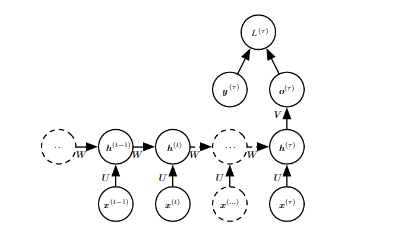

## Model with custom Keras layer
A model consisting of a custom RNN layer and a Dense layer instead of manually multiplying the output state with weights 'V' 

### Rnn_layer

In [ ]:
class Rnn_layer(keras.layers.Layer):

  def __init__(self, initializer, regularizer, hidden_units, **kwargs):
    super(Rnn_layer, self).__init__(**kwargs)
    self.initializer = initializer
    self.regularizer = regularizer
    self.hidden_units = hidden_units


  def get_config(self):
      config = super().get_config().copy()
      config.update({
          'initializer': self.initializer,
          'regularizer': self.regularizer,
          'hidden_units': self.hidden_units
      })
      return config


  def build(self, input_shape):

    # shape of the 'W' weights
    h_weight = (self.hidden_units, self.hidden_units)
    self.W = tf.Variable(self.initializer(shape=h_weight))

    # shape of the 'U' weights
    i_weight = (num_words, self.hidden_units)
    self.U = tf.Variable(self.initializer(shape=i_weight))

    # shape of the bias
    bias = (1, self.hidden_units)
    self.b = tf.Variable(tf.zeros(bias))

    # Relu activation - can also use tanh instead (did not test)
    self.activation = keras.activations.relu 


  @tf.function
  def call(self, sequences):
    
    # initialized initial state with zeros
    h = tf.zeros((1, self.hidden_units))

    for step in range(seq_len):
      x_t = sequences[:, step]
      x_t = tf.one_hot(x_t, depth=num_words)
      # Matmul of weights and states/inputs passed through an activation function
      h = self.activation(h @ self.W + x_t @ self.U + self.b)

    return h

### Model Architecture

In [ ]:
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [keras.metrics.BinaryAccuracy()]

In [ ]:
hidden_units = 100
initializer = keras.initializers.HeNormal()
regularizer = keras.regularizers.L2(1e-4)

In [ ]:
model = tf.keras.models.Sequential([
  Rnn_layer(hidden_units=hidden_units, initializer=initializer, regularizer=regularizer),
  tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

### Train

In [ ]:
rnn_model1 = model.fit(train_sequences, train_labels, batch_size = 100, epochs = 5, validation_data = (test_sequences, test_labels))

Epoch 1/5
250/250 [==============================] - 307s 1s/step - loss: 6.9022 - binary_accuracy: 0.5020 - val_loss: 0.6817 - val_binary_accuracy: 0.5156
Epoch 2/5
250/250 [==============================] - 282s 1s/step - loss: 0.6597 - binary_accuracy: 0.5335 - val_loss: 0.6527 - val_binary_accuracy: 0.5471
Epoch 3/5
250/250 [==============================] - 253s 1s/step - loss: 0.5943 - binary_accuracy: 0.6279 - val_loss: 0.5931 - val_binary_accuracy: 0.6044
Epoch 4/5
250/250 [==============================] - 281s 1s/step - loss: 0.5087 - binary_accuracy: 0.7288 - val_loss: 0.5152 - val_binary_accuracy: 0.7517
Epoch 5/5
250/250 [==============================] - 270s 1s/step - loss: 0.4037 - binary_accuracy: 0.8090 - val_loss: 0.4534 - val_binary_accuracy: 0.8099


### Evaluation

782/782 - 70s - loss: 0.4534 - binary_accuracy: 0.8099 - 70s/epoch - 90ms/step


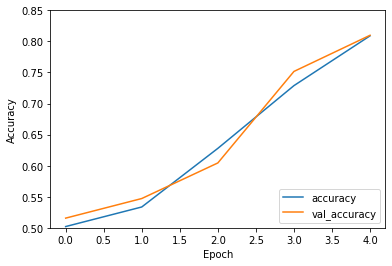

In [ ]:
plt.plot(rnn_model1.history['binary_accuracy'], label='accuracy')
plt.plot(rnn_model1.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 0.85])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_sequences, test_labels, verbose=2)

## Experimental Keras Model
This model does not use the default keras Dense layer but rather a weight 'V' for the output. This model shows potential and had an increase in test accuracy with every epoch, but took longer (more epochs for comparable results) to train. (probably due to a lack of default optimization methods that might be implemented in the default keras Dense layer)

### Rnn_layer

In [ ]:
class Rnn_layer2(keras.layers.Layer):

  def __init__(self, initializer, regularizer, hidden_units, **kwargs):
    super(Rnn_layer2, self).__init__(**kwargs)
    self.initializer = initializer
    self.regularizer = regularizer
    self.hidden_units = hidden_units


  def get_config(self):
      config = super().get_config().copy()
      config.update({
          'initializer': self.initializer,
          'regularizer': self.regularizer,
          'hidden_units': self.hidden_units
      })
      return config


  def build(self, input_shape):

    h_weight = (self.hidden_units, self.hidden_units)
    self.W = tf.Variable(self.initializer(shape=h_weight))

    i_weight = (num_words, self.hidden_units)
    self.U = tf.Variable(self.initializer(shape=i_weight))

    bias = (1, self.hidden_units)
    self.b = tf.Variable(tf.zeros(bias))

    v_weight = (self.hidden_units, 1)
    self.V = tf.Variable(self.initializer(shape=v_weight))

    # self.activation = keras.activations.relu
    self.activation = keras.activations.tanh


  @tf.function
  def call(self, sequences):

    h = tf.zeros((1, self.hidden_units))

    for step in range(seq_len):
      x_t = sequences[:, step]
      x_t = tf.one_hot(x_t, depth=num_words)
      h = self.activation(h @ self.W + x_t @ self.U + self.b)

    # The extra output layer function (an additional output bias could be added too) 
    h = h @ self.V
    
    return h

### Model Architecture

In [ ]:
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [keras.metrics.BinaryAccuracy()]

In [ ]:
hidden_units = 100
initializer = keras.initializers.HeNormal()
regularizer = keras.regularizers.L2(1e-4)

In [ ]:
model2 = tf.keras.models.Sequential([
  Rnn_layer2(hidden_units=hidden_units, initializer=initializer, regularizer=regularizer)
])

In [ ]:
model2.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

### Train
The dataset used for this was given an additional argument (skip_top=10), which resulted in better accuracy/faster training. Without the argument, the model showed around 62% test accuracy after 5 epochs.

In [ ]:
rnn_model2 = model2.fit(train_sequences, train_labels, batch_size = 100, epochs = 5, validation_data = (test_sequences, test_labels))

Epoch 1/5
250/250 [==============================] - 231s 885ms/step - loss: 0.6979 - binary_accuracy: 0.5019 - val_loss: 0.6975 - val_binary_accuracy: 0.5094
Epoch 2/5
250/250 [==============================] - 216s 865ms/step - loss: 0.6878 - binary_accuracy: 0.5056 - val_loss: 0.6836 - val_binary_accuracy: 0.5060
Epoch 3/5
250/250 [==============================] - 217s 868ms/step - loss: 0.6759 - binary_accuracy: 0.5174 - val_loss: 0.6716 - val_binary_accuracy: 0.5235
Epoch 4/5
250/250 [==============================] - 214s 856ms/step - loss: 0.6404 - binary_accuracy: 0.5620 - val_loss: 0.6038 - val_binary_accuracy: 0.6136
Epoch 5/5
250/250 [==============================] - 202s 810ms/step - loss: 0.5163 - binary_accuracy: 0.7118 - val_loss: 0.4365 - val_binary_accuracy: 0.7678


# Food for Thought Questions

## Extra
You may sometimes get a higher test accuracy, while the test loss is also increasing (how can this be?)!

If the loss increases and the accuracy increase too is because your regularization techniques are working well and you're fighting the overfitting problem.

## Question 1:
All sequences are padded to the length of the longest sequence in the dataset. Why is this wasteful? Can you think of a smarter padding scheme that is more efficient? Consider the fact that RNNs can work on arbitrary sequence lengths, and that training minibatches are pretty much independent of each other.

There can be extremely short sequences that may need to be padded with a lot of 0s to ensure every sequence has the same length. Maybe we can create batches out of sequences and then pad them according to the longest sequence in that particular batch.

## Question 2:
Between truncating long sequences and removing them, which option do you think is better? Why?

I think it is better to truncate long sequences as it could be possible that certain long sequences are necessary to train the model to classify a certain output. 

## Question 3:
Can you think of a way to avoid the one-hot vectors completely? Even if you cannot implement it, a conceptual idea is fine.

a one-hot is a group of bits among which the legal combinations of values are only those with a single high (1) bit and all the others low (0)
-> Instead, use word vectors to generate word embeddings, which are "..a real number, vector representation of a word... words with similar meaning will have vector representations that are close together in the embedding space" 

## Question 4:
For the output and loss, you actually have two options:

1.   You could have an output layer with 2 units, and use sparse categorical cross-entropy as before (i.e. softmax activation). Here, whichever output is higher “wins”.
2.   You can have a single output unit and use binary cross-entropy (i.e. sigmoid activation). Here, the output is usually thresholded at 0.5.

How can it be that we can choose how many outputs we have, i.e. how can both be correct? Are there differences between both choices as well as (dis)advantages relative to each other?

Using categorical cross-entropy we provide a classification, let's say 1 or 0, based on the outputs of both output units. The higher value is considered as the prediction. We do the same thing in binary cross-entropy by having just one output unit and providing a threshold. Any value above the threshold can be classified as 1, and anything below as 0. So these two methods technically do the same thing. 

---
(Dis)Advantages?

## Question 5:
All sequences start with the same special “beginning of sequence” token (coded by index 1). Given this fact, is there a point in learning an initial state? Why (not)?

"If there are enough sequences or state resets in the training data (e.g., this will often be the case if we are doing sequence classification), it may make sense to train the initial state as a variable. This way, the model can learn a good default state. If we have only a few state resets, however, training the initial state as a variable may result in overfitting on the start of each sequence."

## Question 6:
pad_sequences allows for pre or post padding. Try both to see the difference. Which option do you think is better? Recall that we use the final time step output from our model.

Pre padding provided better results.
Since we use the final time step output, by pre-padding the sequences, all the zeros would appear at the start, i.e., further away from the output. This ensures that the actual information is closer to the output. (short/long term dependencies?)

## Question 7:
Can you think of a way to prevent the RNN from computing new states on padded time steps? One idea might be to “pass through” the previous state in case the current time step is padding. Note that, within a batch, some sequences might be padded for a given time step while others are not.

We can use the mask parameter, as seen in the Keras RNN layer - "mask: Binary tensor of shape [batch_size, timesteps] indicating whether a given timestep should be masked. An individual True entry indicates that the corresponding timestep should be utilized, while a False entry indicates that the corresponding timestep should be ignored."

## Question 8:


*  Instead of only using the final output, average (or sum?) the logits (pre-sigmoid) of all time steps and use this as the output instead.
*  Instead of the logits, average the states at all time steps and compute the output based on this average state. Is this different from the above option?
*  Compute logits and sigmoids for each output, and average the per-step probabilities.


What could be the advantage of using methods like the above? What are disadvantages? Can you think of other methods to incorporate the full output sequence instead of just the final step?